# Poetry Generator

The purpose of this notebook is to explore the power of LLM and RNN models to generate poetry from using song lyrics as a dataset. The song datasets I plan to use come from a github repo that has various lyrics from many artists written in txt files.
* https://github.com/laxmimerit/poetry-data

### Resources

This has been done before. The articles are references that I used for this notebook.

* https://kgptalkie.medium.com/poetry-generation-using-tensorflow-keras-and-lstm-75c4e4b7f07e
* https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov/notebook
* https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms
* https://www.tensorflow.org/text/tutorials/text_generation

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import random
import re
import string
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-07 17:06:02.336810


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [9]:
def download_preprocess_and_structure_data(url_by_artist: typing.Dict[str, str]) -> pd.DataFrame:
    """ Downloads and structures the data into a pandas DF.

        Args:
            url_by_artist (Dict[str, str]): the url to grab data from for the corresponding artist.

        Returns:
            (DataFrame) the corresponding structured dataframe.
    """
    all_data = []
    pattern = re.compile(r'\s+')

    for artist in url_by_artist:
        sentences = data_toolbox.read_txt_file_from_url(url_by_artist[artist], delimiter='\n')

        for sentence in sentences:
            cleaned_sentence = ml_toolbox.preprocessing.language.clean_text(sentence)

            if len(cleaned_sentence) > 0:
                all_data.append({'artist': artist, 'sentence': cleaned_sentence})

    return pd.DataFrame(all_data)

In [10]:
def generate_poem(seed_texts: typing.List[str],
                  num_preds_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder,
                  char_pred: bool = False) -> str:
    """ Generates a sentence from the seed texts with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_preds_to_create (int): how many predictions (char/word) to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.
            char_pred (bool): whether or not it is character predictions

        Returns:
            (str) the generated text.
    """
    pred_type = 'char' if char_pred else 'word'
    for seed_text in seed_texts:
        generated_text = ml_toolbox.analysis.language.generate_text_from_seed(
            seed_text, num_preds_to_create, model, one_hot, pred_type)
        print(generated_text)

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file from the links below.

* https://github.com/laxmimerit/poetry-data

For this notebook, I am going to limit my datasets to the following artists:

* [The Beatles](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt)
* [Adele](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt)
* [Bob Dylan](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt)
* [Dr. Seuss](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt)

### Constants

In [11]:
DATA_URLS = {
    'beatles': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt',
    'adele': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt',
    'bob_dylan': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt',
    'dr_seuss': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt',
}

### Downloading & Analyzing Data

In [12]:
data_df = download_preprocess_and_structure_data(DATA_URLS)
data_df

,artist,sentence
0,beatles,yesterday all my troubles seemed so far away
1,beatles,now it looks as though theyre here to stay
2,beatles,oh i believe in yesterday suddenly im not half...
3,beatles,theres a shadow hanging over me
4,beatles,oh yesterday came suddenly why she had to go i...
...,...,...
10458,dr_seuss,so we will sleep with our pet zeep
10459,dr_seuss,today is gone today was fun
10460,dr_seuss,tomorrow is another one
10461,dr_seuss,every day from here to there


In [13]:
sentences = data_df.sentence.to_numpy()
sentences[:5]

array(['yesterday all my troubles seemed so far away',
       'now it looks as though theyre here to stay',
       'oh i believe in yesterday suddenly im not half the man i used to be',
       'theres a shadow hanging over me',
       'oh yesterday came suddenly why she had to go i dont know she wouldnt say'],
      dtype=object)

In [14]:
sentences[-5:]

array(['so we will sleep with our pet zeep',
       'today is gone today was fun', 'tomorrow is another one',
       'every day from here to there', 'funny things are everywhere'],
      dtype=object)

In [15]:
# Seeing the vocab
word_counts = ml_toolbox.analysis.language.get_word_counts(sentences)

len(word_counts)

5924

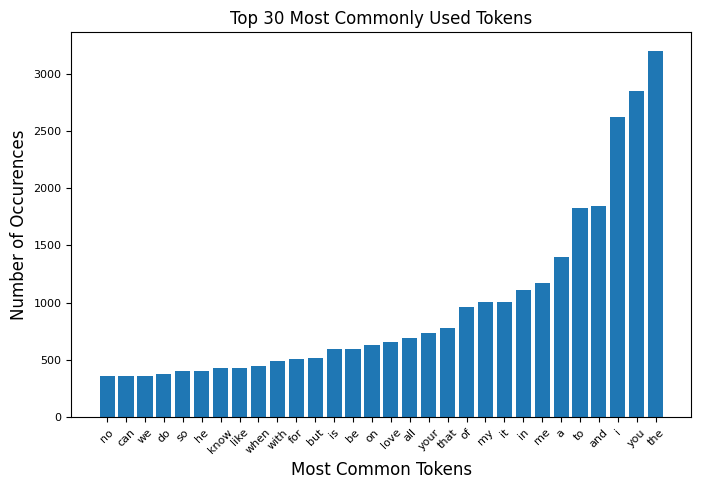

In [16]:
ml_toolbox.analysis.language.plot_token_counts(word_counts, most_common=True, n=30)

In [17]:
# Seeing the Characters
character_counts = ml_toolbox.analysis.language.get_character_counts(sentences)

len(character_counts)

41

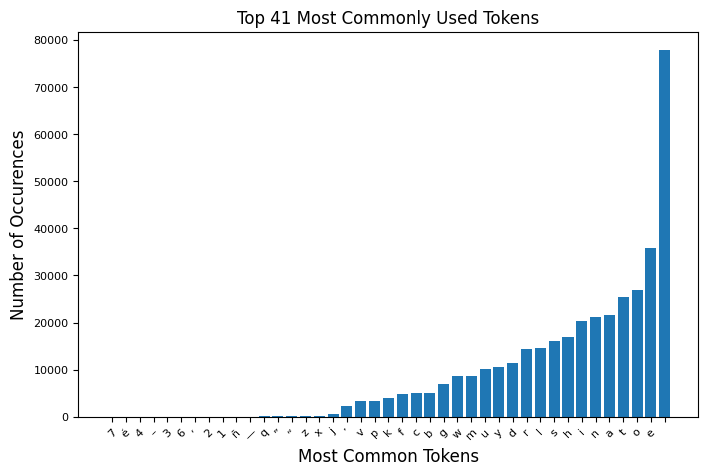

In [18]:
ml_toolbox.analysis.language.plot_token_counts(character_counts, most_common=True, n=41)

### Creating Training Data

In [19]:
X, y = ml_toolbox.preprocessing.language.create_sequenced_data_labels_from_sentences(sentences)
X[:3], y[:3]

(['yesterday', 'yesterday all', 'yesterday all my'], ['all', 'my', 'troubles'])

In [20]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(np.array(list(word_counts)).reshape((-1,1)))

y_one_hot_encoded = one_hot_encoder.transform(np.array(y).reshape((-1,1)))

y_one_hot_encoded.shape

(67374, 5924)

In [21]:
X_char, y_char = ml_toolbox.preprocessing.language.create_sequenced_data_labels_from_sentences(sentences, 'character')

X_char[:15], y_char[:15]

(['y',
  'ye',
  'yes',
  'yest',
  'yeste',
  'yester',
  'yesterd',
  'yesterda',
  'yesterday',
  'yesterday ',
  'yesterday a',
  'yesterday al',
  'yesterday all',
  'yesterday all ',
  'yesterday all m'],
 ['e', 's', 't', 'e', 'r', 'd', 'a', 'y', ' ', 'a', 'l', 'l', ' ', 'm', 'y'])

In [22]:
char_one_hot_encoder = OneHotEncoder(sparse_output=False)

char_one_hot_encoder.fit_transform(np.array(list(character_counts)).reshape((-1,1)))

y_char_one_hot_encoded = char_one_hot_encoder.transform(np.array(y_char).reshape((-1,1)))

y_char_one_hot_encoded.shape

(356433, 41)

### Creating Datasets

In [23]:
train_dataset = data_toolbox.datasets.generate_dataset_from_data([X], y_one_hot_encoded)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 5924), dtype=tf.float64, name=None))>

In [24]:
train_char_dataset = data_toolbox.datasets.generate_dataset_from_data([X_char], y_char_one_hot_encoded)
train_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 41), dtype=tf.float64, name=None))>

## Experiments

I am going to run a handful of experiments to try and generate poems, as listed below:

* Experiment-0 (Baseline): LSTM w/ Token Embeddings
* Experiment-1: Universal Sentence Encoder w/ Token Embeddings
* Experiment-2: Conv1D w/ Token Embeddings
* Experiment-3: Bidirectional LSTM w/ Token Embeddings
* Experiment-4: LSTM w/ Character Embeddings
* Experiment-5: LSTM w/ Token Embeddings + Character Embeddings
* Experiment-6: Bidirectional LSTM w/ Token Embeddings + Character Embeddings
* Experiment-7: LSTM w/ Character Embeddings, Character Level Prediction
* Experiment-8: Bidirectional LSTM w/ Character EMbeddings, Character Level Prediction

### Constants

In [25]:
TOTAL_WORDS = len(word_counts)
TOTAL_CHARS = len(character_counts)

UNIVERSAL_SENTENCE_ENCODER_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

TEST_SEED_TEXTS = [
    'Love is true',
    'Tomorrow comes',
    'Yesterday we',
    'But today',
]

### Preprocessing Layer Setup

Many embedding layers will be reused for more than one of the experiments mentioned above. These steps will setup the layers to be used in experiments such that they can be reused for multiple models. The various layers to be made are:

* `text_vectorizer` (TextVectorizer)
* `token_embedding` (Embedding)
* `character_vectorizer` (TextVectorizer)
* `character_embeddings` (Embedding)

#### Token Embeddings

In [26]:
# Find average number of tokens
sent_lens = [len(sentence.split()) for sentence in sentences]
round(sum(sent_lens) / len(sentences))

7

In [27]:
max(sent_lens)

34

In [28]:
# How long of a sentence covers 98% of the examples?
int(np.percentile(sent_lens, 98))

16

In [29]:
# Setup text vectorization params
max_vocab_length = 10000  # Max words to have in our vocab
max_length = 16

In [30]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

# Adapt the vectorizer to the training data
text_vectorizer.adapt(sentences)

In [31]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]

len(words_in_vocab), top_5_words, least_common_5_words

(5926,
 ['', '[UNK]', 'the', 'you', 'i'],
 ['abel', 'abeatin’', 'abandon', 'aaaaahhhhhhhhhh', '61”'])

In [32]:
# Setting up the Embedding layer
token_embedding = tf.keras.layers.Embedding(input_dim=len(words_in_vocab),
                                            output_dim=128,  # GPU's work well when number is divisible by 8
                                            mask_zero=True,
                                            name='token_embedding')
token_embedding

In [33]:
# Testing out an example sentence
target_sentence = random.choice(sentences)

# Looking at the steps of tokenization
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 no you wont
Sentence after vectorization: 
 [[ 31   3 177   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Sentence after embedding: 
 [[[ 0.03658933  0.02981481 -0.04541545 ... -0.00927724 -0.0237921
    0.00243486]
  [ 0.02453229  0.03825616 -0.01146387 ... -0.00342346 -0.02422233
    0.00534502]
  [-0.0481883  -0.04011912  0.01640696 ...  0.02791115  0.02513263
   -0.03325168]
  ...
  [ 0.02924972  0.04689277 -0.04015032 ...  0.03864879  0.00762683
    0.02556599]
  [ 0.02924972  0.04689277 -0.04015032 ...  0.03864879  0.00762683
    0.02556599]
  [ 0.02924972  0.04689277 -0.04015032 ...  0.03864879  0.00762683
    0.02556599]]]
Embedded sentence shape: (1, 16, 128)


#### Character Embeddings

In [34]:
# Find average number of tokens
char_lens = [len(sentence) for sentence in sentences]
round(sum(char_lens) / len(sentences))

35

In [35]:
max(char_lens)

150

In [36]:
# How long of a sentence covers 98% of the examples?
output_sequence_len = int(np.percentile(char_lens, 98))
output_sequence_len

74

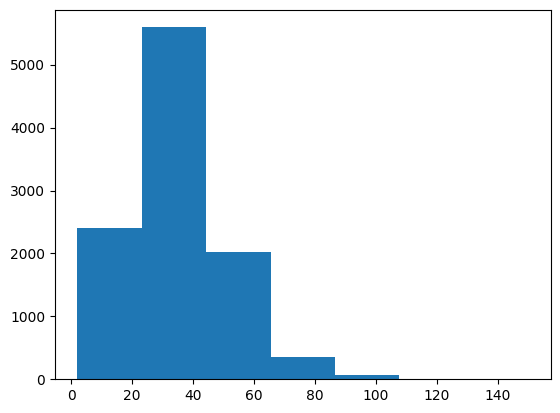

In [37]:
plt.hist(char_lens, bins=7);

In [38]:
# Figuring out the total alpha-numeric characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation

alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # Add 2 for space and OOV token ([UNK])
NUM_CHAR_TOKENS

70

In [40]:
# Setting up a text vectorization layer (tokenization)
character_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_sequence_len,
    split='character',
    name='char_vectorizer')

# Adapt the vectorizer to the training data
character_vectorizer.adapt(X)

In [41]:
char_vocab = character_vectorizer.get_vocabulary()
print(f'Number of Different Characters: {len(char_vocab)}')
print(f'5 Most Common Characters: {char_vocab[:5]}')
print(f'5 Least Common Characters: {char_vocab[-5:]}')

Number of Different Characters: 42
5 Most Common Characters: ['', '[UNK]', ' ', 'e', 't']
5 Least Common Characters: ['2', '3', '7', '4', 'é']


In [42]:
character_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                                output_dim=25,
                                                mask_zero=True,
                                                name='character_embedding')
character_embedding

In [43]:
# Testing out an example sentence
target_chars = random.choice(X_char)

# Looking at the steps of tokenization
print(f'Chars before vectorization: \n {target_chars}')

vectorized_chars = character_vectorizer([target_chars])
print(f'Chars after vectorization: \n {vectorized_chars}')
embedded_chars = character_embedding(vectorized_chars)
print(f'Chars after embedding: \n {embedded_chars}')
print(f'Embedded chars shape: {embedded_chars.shape}')

Chars before vectorization: 
 and y
Chars after vectorization: 
 [[ 6  8 13  2 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
Chars after embedding: 
 [[[-0.04791464 -0.04099488  0.0150761  ...  0.02397181 -0.04402543
    0.01575801]
  [ 0.00045465  0.00881197  0.03332895 ... -0.00246448 -0.02928641
    0.0404681 ]
  [ 0.04236162 -0.03328198 -0.03560229 ...  0.01963707 -0.01296594
   -0.03676645]
  ...
  [-0.02129905  0.04043912 -0.01202876 ...  0.00382083  0.03552635
   -0.01343925]
  [-0.02129905  0.04043912 -0.01202876 ...  0.00382083  0.03552635
   -0.01343925]
  [-0.02129905  0.04043912 -0.01202876 ...  0.00382083  0.03552635
   -0.01343925]]]
Embedded chars shape: (1, 74, 25)


### Experiment-0 (Baseline): LSTM with Token Embeddings

For a baseline, going to use a very simple model with only a single LSTM layer.

In [44]:
# Constants
model_0_name = 'model_0_simple_lstm'

In [45]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)
model_0.summary()

Model: "model_0_simple_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           758528    
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5924)              385060    
                                                                 
Total params: 1192996 (4.55 MB)
Trainable param

In [46]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [47]:
model_0.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 25s 11ms/step - loss: 6.7064 - accuracy: 0.0465
Epoch 2/10
2106/2106 [==============================] - 26s 12ms/step - loss: 6.0388 - accuracy: 0.0643
Epoch 3/10
2106/2106 [==============================] - 28s 13ms/step - loss: 5.6066 - accuracy: 0.0912
Epoch 4/10
2106/2106 [==============================] - 29s 14ms/step - loss: 5.2641 - accuracy: 0.1156
Epoch 5/10
2106/2106 [==============================] - 28s 13ms/step - loss: 4.9583 - accuracy: 0.1387
Epoch 6/10
2106/2106 [==============================] - 28s 13ms/step - loss: 4.6744 - accuracy: 0.1654
Epoch 7/10
2106/2106 [==============================] - 28s 13ms/step - loss: 4.4205 - accuracy: 0.1930
Epoch 8/10
2106/2106 [==============================] - 26s 12ms/step - loss: 4.1904 - accuracy: 0.2199
Epoch 9/10
2106/2106 [==============================] - 26s 13ms/step - loss: 3.9806 - accuracy: 0.2482
Epoch 10/10
2106/2106 [==============================] - 24s 12m

In [48]:
generate_poem(TEST_SEED_TEXTS, 8, model_0, one_hot_encoder)

Love is true love he can have a little bit more
Tomorrow comes some day ham the chimney with his toys
Yesterday we will eat them in the tree in the
But today is a mouse with a mouse not the


### Experiment-1: Universal Sentence Encoder with Token Embeddings

In [49]:
# Constants
model_1_name = 'model_1_use'

In [51]:
# Build Model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(UNIVERSAL_SENTENCE_ENCODER_URL,
                                      trainable=False,
                                      name='USE')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 660.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_1_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense

In [52]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [53]:
model_1.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 10s 4ms/step - loss: 6.6464 - accuracy: 0.0526
Epoch 2/10
2106/2106 [==============================] - 9s 4ms/step - loss: 5.9820 - accuracy: 0.0668
Epoch 3/10
2106/2106 [==============================] - 9s 4ms/step - loss: 5.6188 - accuracy: 0.0796
Epoch 4/10
2106/2106 [==============================] - 9s 4ms/step - loss: 5.2503 - accuracy: 0.0924
Epoch 5/10
2106/2106 [==============================] - 9s 4ms/step - loss: 4.8700 - accuracy: 0.1126
Epoch 6/10
2106/2106 [==============================] - 9s 4ms/step - loss: 4.4935 - accuracy: 0.1409
Epoch 7/10
2106/2106 [==============================] - 9s 4ms/step - loss: 4.1609 - accuracy: 0.1744
Epoch 8/10
2106/2106 [==============================] - 9s 4ms/step - loss: 3.8878 - accuracy: 0.2062
Epoch 9/10
2106/2106 [==============================] - 9s 4ms/step - loss: 3.6646 - accuracy: 0.2398
Epoch 10/10
2106/2106 [==============================] - 9s 4ms/step - loss: 3.48

In [54]:
generate_poem(TEST_SEED_TEXTS, 8, model_1, one_hot_encoder)

Love is true with evil with flesh with with nor nor
Tomorrow comes come come above come come on come on
Yesterday we in today today days is is is is
But today is no no no no no no no


### Experiment-2: Conv1D with Token Embeddings

In [55]:
# Constants
model_2_name = 'model_2_conv1d_token'

In [56]:
# Build Model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)
model_2.summary()

Model: "model_2_conv1d_token"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           758528    
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 16, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                              

In [57]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [58]:
model_2.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 12s 6ms/step - loss: 6.3533 - accuracy: 0.0807
Epoch 2/10
2106/2106 [==============================] - 13s 6ms/step - loss: 5.4271 - accuracy: 0.1282
Epoch 3/10
2106/2106 [==============================] - 14s 7ms/step - loss: 4.9402 - accuracy: 0.1599
Epoch 4/10
2106/2106 [==============================] - 14s 6ms/step - loss: 4.5265 - accuracy: 0.1927
Epoch 5/10
2106/2106 [==============================] - 13s 6ms/step - loss: 4.1469 - accuracy: 0.2283
Epoch 6/10
2106/2106 [==============================] - 13s 6ms/step - loss: 3.8045 - accuracy: 0.2653
Epoch 7/10
2106/2106 [==============================] - 14s 6ms/step - loss: 3.5062 - accuracy: 0.3003
Epoch 8/10
2106/2106 [==============================] - 13s 6ms/step - loss: 3.2561 - accuracy: 0.3328
Epoch 9/10
2106/2106 [==============================] - 13s 6ms/step - loss: 3.0377 - accuracy: 0.3656
Epoch 10/10
2106/2106 [==============================] - 13s 6ms/step - l

In [59]:
generate_poem(TEST_SEED_TEXTS, 8, model_2, one_hot_encoder)

Love is true love with your eyes that that is that
Tomorrow comes and i do not like them and a
Yesterday we are busy with their tree and he likes
But today is getting president of the tree that the


### Experiment-3: Bidirectional LSTM with Token Embeddings

In [60]:
# Constants
model_3_name = 'model_3_bidirectional_lstm'

In [61]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)
model_3.summary()

Model: "model_3_bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           758528    
 )                                                               
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 5924)              764196    
                                        

In [62]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [63]:
model_3.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 31s 13ms/step - loss: 6.1444 - accuracy: 0.0899
Epoch 2/10
2106/2106 [==============================] - 27s 13ms/step - loss: 5.0796 - accuracy: 0.1525
Epoch 3/10
2106/2106 [==============================] - 26s 12ms/step - loss: 4.4624 - accuracy: 0.2061
Epoch 4/10
2106/2106 [==============================] - 25s 12ms/step - loss: 3.9683 - accuracy: 0.2569
Epoch 5/10
2106/2106 [==============================] - 25s 12ms/step - loss: 3.5744 - accuracy: 0.3080
Epoch 6/10
2106/2106 [==============================] - 27s 13ms/step - loss: 3.2407 - accuracy: 0.3576
Epoch 7/10
2106/2106 [==============================] - 26s 12ms/step - loss: 2.9576 - accuracy: 0.4005
Epoch 8/10
2106/2106 [==============================] - 25s 12ms/step - loss: 2.7181 - accuracy: 0.4425
Epoch 9/10
2106/2106 [==============================] - 25s 12ms/step - loss: 2.5168 - accuracy: 0.4786
Epoch 10/10
2106/2106 [==============================] - 25s 12m

In [64]:
generate_poem(TEST_SEED_TEXTS, 8, model_3, one_hot_encoder)

Love is true love is love to you that i do
Tomorrow comes down the chimney and bags in a bed
Yesterday we know we saw it coming there and i
But today has to be in a tree from my


### Experiment-4: LSTM with Character Embeddings

In [65]:
# Constants
model_4_name = 'model_4_lstm_char'

In [66]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)
model_4.summary()

Model: "model_4_lstm_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 74)                0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 74, 25)            1050      
 ding)                                                           
                                                                 
 lstm_2 (LSTM)               (None, 64)                23040     
                                                                 
 dense_5 (Dense)             (None, 5924)              385060    
                                                                 
Total params: 409150 (1.56 MB)
Trainable params: 

In [67]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [68]:
model_4.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 42s 19ms/step - loss: 6.7202 - accuracy: 0.0454
Epoch 2/10
2106/2106 [==============================] - 40s 19ms/step - loss: 6.3644 - accuracy: 0.0465
Epoch 3/10
2106/2106 [==============================] - 40s 19ms/step - loss: 6.2359 - accuracy: 0.0488
Epoch 4/10
2106/2106 [==============================] - 40s 19ms/step - loss: 6.0497 - accuracy: 0.0529
Epoch 5/10
2106/2106 [==============================] - 40s 19ms/step - loss: 5.8329 - accuracy: 0.0613
Epoch 6/10
2106/2106 [==============================] - 40s 19ms/step - loss: 5.6252 - accuracy: 0.0674
Epoch 7/10
2106/2106 [==============================] - 40s 19ms/step - loss: 5.4423 - accuracy: 0.0745
Epoch 8/10
2106/2106 [==============================] - 40s 19ms/step - loss: 5.2783 - accuracy: 0.0814
Epoch 9/10
2106/2106 [==============================] - 40s 19ms/step - loss: 5.1433 - accuracy: 0.0874
Epoch 10/10
2106/2106 [==============================] - 40s 19m

In [69]:
generate_poem(TEST_SEED_TEXTS, 8, model_4, one_hot_encoder)

Love is true fish nah nah nah nah nah nah nah
Tomorrow comes and he saw i will a mouse is
Yesterday we a little bit the grinch a mouse is
But today and he was are is a little bit


### Experiment-5: LSTM with Character Embeddings & Token Embeddings

In [70]:
# Constants
model_5_name = 'model_5_lstm_char_token'

In [71]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Token Embedding
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
token_lstm = tf.keras.layers.LSTM(64)(x)

token_model = tf.keras.models.Model(inputs, token_lstm, name=model_5_name)

# Character Embedding
x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
char_lstm = tf.keras.layers.LSTM(64)(x)

character_model = tf.keras.models.Model(inputs, char_lstm, name=model_5_name)

# Concatenating outputs
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, character_model.output])

# Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(final_dropout)

model_5 = tf.keras.models.Model(inputs=inputs,
                                outputs=outputs,
                                name=model_5_name)
model_5.summary()

Model: "model_5_lstm_char_token"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 16)                   0         ['input_7[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 74)                   0         ['input_7[0][0]']             
 rization)                                                                                        
                                                                            

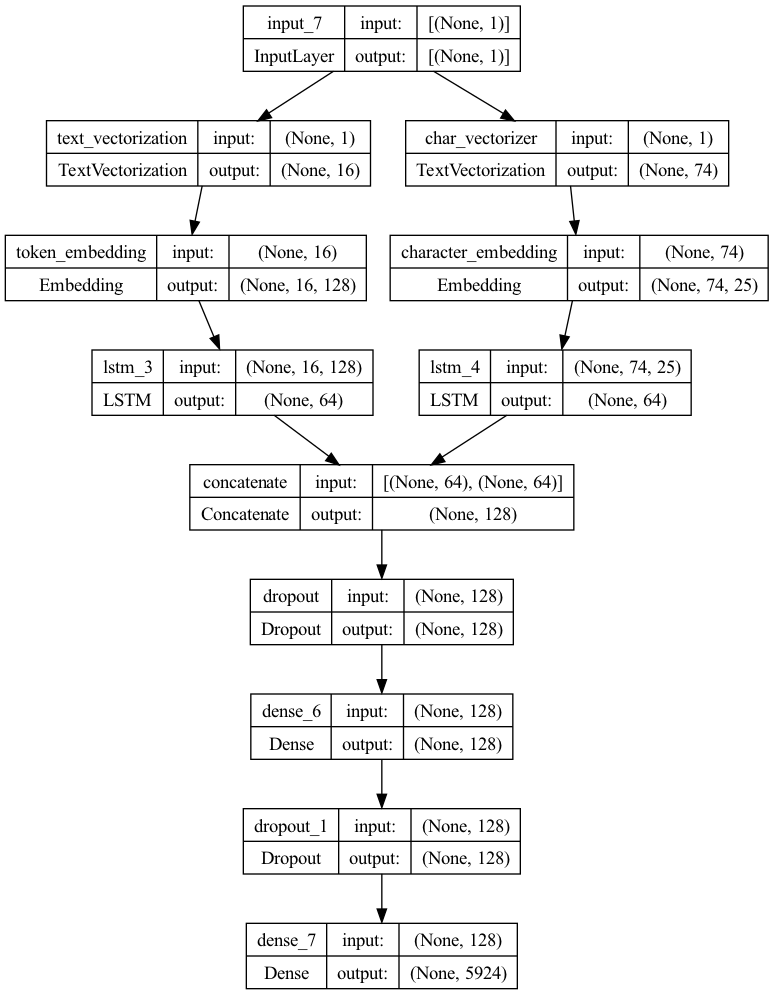

In [72]:
ml_toolbox.analysis.model.plot_model(model_5)

In [73]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [74]:
model_5.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 47s 21ms/step - loss: 6.4421 - accuracy: 0.0677
Epoch 2/10
2106/2106 [==============================] - 43s 20ms/step - loss: 5.7893 - accuracy: 0.1024
Epoch 3/10
2106/2106 [==============================] - 43s 20ms/step - loss: 5.5347 - accuracy: 0.1175
Epoch 4/10
2106/2106 [==============================] - 43s 20ms/step - loss: 5.3508 - accuracy: 0.1284
Epoch 5/10
2106/2106 [==============================] - 43s 20ms/step - loss: 5.1980 - accuracy: 0.1397
Epoch 6/10
2106/2106 [==============================] - 43s 20ms/step - loss: 5.0713 - accuracy: 0.1450
Epoch 7/10
2106/2106 [==============================] - 43s 20ms/step - loss: 4.9671 - accuracy: 0.1520
Epoch 8/10
2106/2106 [==============================] - 43s 20ms/step - loss: 4.8859 - accuracy: 0.1586
Epoch 9/10
2106/2106 [==============================] - 43s 20ms/step - loss: 4.8082 - accuracy: 0.1624
Epoch 10/10
2106/2106 [==============================] - 43s 20m

In [75]:
generate_poem(TEST_SEED_TEXTS, 8, model_5, one_hot_encoder)

Love is true love is a house a house a house
Tomorrow comes and he is a house in a house
Yesterday we will be a house the house is a
But today is a house a house a house a


### Experiment-6: Bidirectional LSTM w/ Character Embeddings & Token Embeddings

In [76]:
# Constants
model_6_name = 'model_6_bidirectional_lstm_char_token'

In [77]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Token Embedding
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
token_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

token_model = tf.keras.models.Model(inputs, token_lstm, name=model_5_name)

# Character Embedding
x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
char_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

character_model = tf.keras.models.Model(inputs, char_lstm, name=model_5_name)

# Concatenating outputs
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, character_model.output])

# Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(final_dropout)

model_6 = tf.keras.models.Model(inputs=inputs,
                                outputs=outputs,
                                name=model_6_name)
model_6.summary()

Model: "model_6_bidirectional_lstm_char_token"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 16)                   0         ['input_8[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 char_vectorizer (TextVecto  (None, 74)                   0         ['input_8[0][0]']             
 rization)                                                                                        
                                                              

In [78]:
model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [79]:
model_6.fit(train_dataset, epochs=10)

Epoch 1/10
2106/2106 [==============================] - 52s 22ms/step - loss: 6.3809 - accuracy: 0.0719
Epoch 2/10
2106/2106 [==============================] - 46s 22ms/step - loss: 5.6708 - accuracy: 0.1118
Epoch 3/10
2106/2106 [==============================] - 45s 22ms/step - loss: 5.3822 - accuracy: 0.1338
Epoch 4/10
2106/2106 [==============================] - 46s 22ms/step - loss: 5.1843 - accuracy: 0.1456
Epoch 5/10
2106/2106 [==============================] - 46s 22ms/step - loss: 5.0241 - accuracy: 0.1548
Epoch 6/10
2106/2106 [==============================] - 46s 22ms/step - loss: 4.8941 - accuracy: 0.1612
Epoch 7/10
2106/2106 [==============================] - 46s 22ms/step - loss: 4.7942 - accuracy: 0.1703
Epoch 8/10
2106/2106 [==============================] - 46s 22ms/step - loss: 4.7067 - accuracy: 0.1760
Epoch 9/10
2106/2106 [==============================] - 46s 22ms/step - loss: 4.6292 - accuracy: 0.1824
Epoch 10/10
2106/2106 [==============================] - 45s 22m

In [80]:
generate_poem(TEST_SEED_TEXTS, 8, model_5, one_hot_encoder)

Love is true love to you and i will not eat
Tomorrow comes on the house the house the house the
Yesterday we will be a tree and i will not
But today is a house a house a house a


### Experiment-7: LSTM w/ Character Embeddings, Character Level Prediction

In [81]:
# Constants
model_7_name = 'model_7_lstm_char_pred'

In [82]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_CHARS, activation='softmax')(x)

model_7 = tf.keras.models.Model(inputs, outputs, name=model_7_name)
model_7.summary()

Model: "model_7_lstm_char_pred"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 74)                0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 74, 25)            1050      
 ding)                                                           
                                                                 
 lstm_7 (LSTM)               (None, 64)                23040     
                                                                 
 dense_10 (Dense)            (None, 41)                2665      
                                                                 
Total params: 26755 (104.51 KB)
Trainable pa

In [83]:
model_7.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [84]:
model_7.fit(train_char_dataset, epochs=10)

Epoch 1/10
11139/11139 [==============================] - 202s 18ms/step - loss: 1.9523 - accuracy: 0.4216
Epoch 2/10
11139/11139 [==============================] - 200s 18ms/step - loss: 1.6431 - accuracy: 0.5041
Epoch 3/10
11139/11139 [==============================] - 200s 18ms/step - loss: 1.5506 - accuracy: 0.5297
Epoch 4/10
11139/11139 [==============================] - 204s 18ms/step - loss: 1.4978 - accuracy: 0.5449
Epoch 5/10
11139/11139 [==============================] - 205s 18ms/step - loss: 1.4646 - accuracy: 0.5550
Epoch 6/10
11139/11139 [==============================] - 204s 18ms/step - loss: 1.4413 - accuracy: 0.5612
Epoch 7/10
11139/11139 [==============================] - 199s 18ms/step - loss: 1.4228 - accuracy: 0.5665
Epoch 8/10
11139/11139 [==============================] - 199s 18ms/step - loss: 1.4077 - accuracy: 0.5711
Epoch 9/10
11139/11139 [==============================] - 199s 18ms/step - loss: 1.3953 - accuracy: 0.5748
Epoch 10/10
11139/11139 [============

In [85]:
generate_poem(TEST_SEED_TEXTS, 40, model_7, char_one_hot_encoder, char_pred=True)

Love is true the house i can say the ship and the sh
Tomorrow comes the shine the street the ship and the s
Yesterday we say the ship and the shine the street t
But today and the shine the street the ship and t


### Experiment-8: Bidirectional LSTM w/ Character Embeddings, Character Level Prediction

In [86]:
# Constants
model_8_name = 'model_8_bidirectional_lstm_char_pred'

In [87]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)  # Turn the input text into numbers
x = character_embedding(x)  # Embed the text
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(TOTAL_CHARS, activation='softmax')(x)

model_8 = tf.keras.models.Model(inputs, outputs, name=model_8_name)
model_8.summary()

Model: "model_8_bidirectional_lstm_char_pred"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 74)                0         
 rization)                                                       
                                                                 
 character_embedding (Embed  (None, 74, 25)            1050      
 ding)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               46080     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 41)                5289      
                              

In [88]:
model_8.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [89]:
model_8.fit(train_char_dataset, epochs=5)

Epoch 1/5
11139/11139 [==============================] - 210s 19ms/step - loss: 1.8447 - accuracy: 0.4524
Epoch 2/5
11139/11139 [==============================] - 203s 18ms/step - loss: 1.5914 - accuracy: 0.5192
Epoch 3/5
11139/11139 [==============================] - 203s 18ms/step - loss: 1.5054 - accuracy: 0.5439
Epoch 4/5
11139/11139 [==============================] - 202s 18ms/step - loss: 1.4526 - accuracy: 0.5597
Epoch 5/5
11139/11139 [==============================] - 205s 18ms/step - loss: 1.4152 - accuracy: 0.5709


In [90]:
generate_poem(TEST_SEED_TEXTS, 40, model_8, char_one_hot_encoder, char_pred=True)

Love is true now you say to have to the hop of the h
Tomorrow comes and he say the hop a hop a hop a hop a 
Yesterday we will all the hop and he say the hop and
But today a house heart to heart to heart to hear
